In [128]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np

N_DENSE = 2

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
def get_mnist(train=True, train_percent=80):       
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    if train:
        return x_train[:4000], y_train[:4000]
    return x_test[:4000], y_test[:4000]

In [131]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(28, 28, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(units=28*28),
        keras.layers.Reshape(target_shape=(28, 28, 1))
    ]
)

In [132]:
simp_ae.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 latent_space (Dense)        (None, 2)                 1568      
                                                                 
 dense_10 (Dense)            (None, 784)               2352      
                                                                 
 reshape_5 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 3,920
Trainable params: 3,920
Non-trainable params: 0
_________________________________________________________________


In [133]:
x, y = get_mnist()

In [134]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir='tb_log_dir_notebook',
    histogram_freq=2,  
    write_graph=True,
    write_images=True
)

In [135]:
simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [153]:
simp_ae.fit(
    batch_size=16,
    x=x,
    y=x,
    epochs=100,
    callbacks=[tb_callback]
)

Epoch 1/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1294
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1294
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1294
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1293
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1295
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0553 - mae: 0.1294
Epoch 7/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1294
Epoch 8/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0552 - mae: 0.1293
Epoch 9/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0553 - mae: 0.1294
Epoch 10/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0552 - mae: 0.1294
Epoch 11/100
250/250 [=================

In [157]:
mid_layer = simp_ae.get_layer('latent_space')

In [158]:
len(mid_layer.get_weights()[0])

784

In [159]:
mid_layer.get_weights()[0].shape

(784, 2)

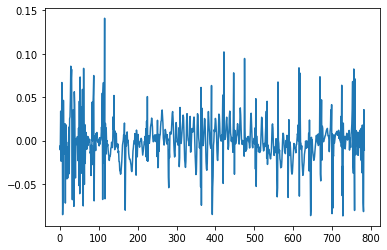

In [160]:
plt.plot(mid_layer.get_weights()[0][:,0])

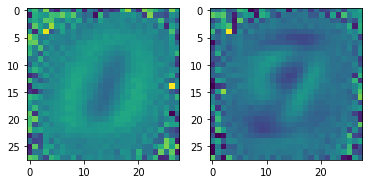

In [168]:
fig, axes = plt.subplots(1,N_DENSE)
for i, ax in enumerate(axes.flat):
    ax.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(28,28))

# Plot input and output images

In [51]:
predictions = simp_ae.predict(x[:2])

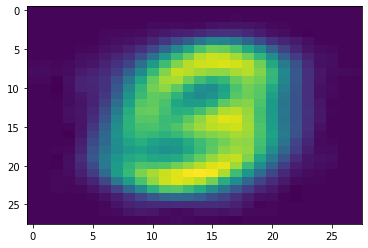

In [53]:
plt.imshow(predictions[0], aspect='auto', cmap='viridis')

# Plot the latent space

In [21]:
desired_output_layers = ['dense']

desired_outputs = []
for desred_layer_name in desired_output_layers:
    desired_outputs.append(simp_ae.get_layer(desred_layer_name).output)

activation_model = keras.Model(simp_ae.inputs, desired_outputs)

In [22]:
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________


In [38]:
full_latent_out = activation_model.predict(x)

In [40]:
full_latent_out

array([[-2.8572304 , -2.8265011 ],
       [-5.1372027 , -0.77486914],
       [-2.1498282 ,  0.38075435],
       ...,
       [-3.4423344 , -2.7731953 ],
       [-3.9726212 ,  0.47921735],
       [-2.958331  , -0.06612295]], dtype=float32)

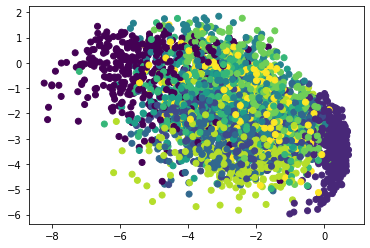

In [41]:
plt.scatter(full_latent_out[:,0], full_latent_out[:, 1], c = y)

# PCA

In [144]:
l = []
for i, cur_x in enumerate(x):
    l.append(cur_x.flatten())

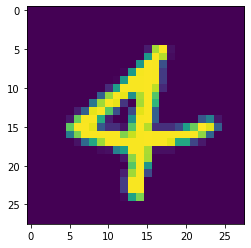

In [145]:
plt.imshow(l[150].reshape(28,28))

In [146]:
img_pca = PCA(n_components=N_DENSE)

In [147]:
img_pca.fit(l)

PCA(n_components=2)

In [148]:
components = img_pca.transform(l)

In [149]:
components.shape

(4000, 2)

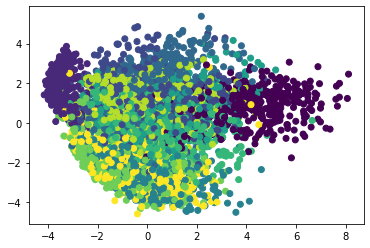

In [150]:
plt.scatter(components[:,0], components[:,1], c=y)

In [151]:
img_pca.components_.shape

(2, 784)

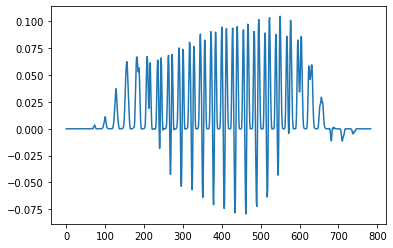

In [72]:
plt.plot(img_pca.components_[0])

# Compare

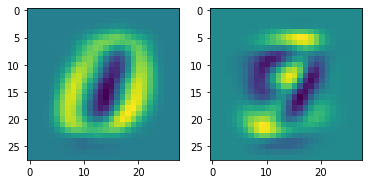

In [164]:
fig_pca, axes_pca = plt.subplots(1,N_DENSE)
for i, ax in enumerate(axes_pca.flat):
    ax.imshow(img_pca.components_[i].reshape(28,28))